In [1]:
import os
import sys
# SRC_DIR environment variable should be the absolute path to the 'multicopy-STR-genotyping' directory
sys.path.append(os.environ["SRC_DIR"])

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from multicopy_STR_genotyping import file_io

sns.set_context("poster")
%matplotlib inline

In [116]:
df_repeats, df_hg002 = file_io.dfs_from_vcf(filename="../../data/HG002/variants/HipSTR/2024-07-08_hg002_HipSTR.vcf", samples=["HG002"], vcf_format="HipSTR")
print(df_repeats.shape, df_hg002.shape)

df_covered_repeats = pd.read_csv("../../data/HG002/regions/hg38_ver13_0boe_mononucleotides_union.bed", sep="\t", names=["chr", "start", "end", "period", "unit"])
df_covered_repeats = df_covered_repeats.assign(
            str_id = np.array([f"{chrom}_{start + 1}" for chrom, start in zip(df_covered_repeats.chr, df_covered_repeats.start)])
)

df_covered_repeats = df_repeats[df_repeats["str_id"].isin(df_covered_repeats["str_id"])]

autosomes = [f"chr{i}" for i in range(1, 23)]
df_hg002 = df_hg002.merge(
    df_covered_repeats[["str_id", "chr", "start", "end", "period", "unit", "ref"]], on="str_id", how="inner"
).assign(
    copy_number = lambda x: [2 if i in autosomes else 1 for i in x["chr"]] # HipSTR doesn't include CN so we add it manually here
).dropna().reset_index(drop=True)

print(df_covered_repeats.shape, df_hg002.shape)

df_hg002


(1672353, 7) (1672353, 5)
(1565743, 7) (1225858, 11)


,sample,str_id,copy_number,frequencies,genotype,chr,start,end,period,unit,ref
0,HG002,chr1_588068,2,{12: 22},"[12, 12]",chr1,588068,588079,3,CCT,12
1,HG002,chr1_590659,2,{12: 56},"[12, 12]",chr1,590659,590670,4,AAAT,12
2,HG002,chr1_590969,2,{16: 38},"[16, 16]",chr1,590969,590984,4,AAAC,16
3,HG002,chr1_594083,2,{12: 21},"[12, 12]",chr1,594083,594094,3,TCC,12
4,HG002,chr1_597686,2,"{14: 33, 17: 1}","[14, 14]",chr1,597686,597699,1,A,14
...,...,...,...,...,...,...,...,...,...,...,...
1225853,HG002,chrY_26622472,1,{10: 28},"[10, 10]",chrY,26622472,26622481,5,AAATA,10
1225854,HG002,chrY_26627699,1,{12: 24},"[12, 12]",chrY,26627699,26627710,3,GAA,12
1225855,HG002,chrY_26628607,1,{15: 31},"[15, 15]",chrY,26628607,26628621,5,ATTTT,15
1225856,HG002,chrY_26635262,1,{10: 35},"[10, 10]",chrY,26635262,26635271,1,A,10


In [1]:
sex_chromosomes = ((df_hg002["chr"] == 'chrX') | (df_hg002["chr"] == 'chrY'))

updated_gts = list(df_hg002[~sex_chromosomes]["genotype"])
for gt in df_hg002.loc[sex_chromosomes]["genotype"]:
    if gt[0] == gt[1]:
        updated_gts.append([gt[0]])
    else:
        updated_gts.append(np.nan)

df_hg002["genotype"] = updated_gts
# df_hg002 = df_hg002[~df_hg002["genotype"].isna()]
df_hg002 = df_hg002.dropna(axis=0, subset="genotype").reset_index(drop=True)
df_hg002

NameError: name 'df_hg002' is not defined

In [117]:
df_hg002 = df_hg002.assign(
    illumina_region_len = lambda x: [sorted(gt) for gt in x["genotype"]],
    depth = lambda x: [sum(i.values()) for i in x["frequencies"]],
)
df_hg002

,sample,str_id,copy_number,frequencies,genotype,chr,start,end,period,unit,ref,illumina_region_len,depth
0,HG002,chr1_588068,2,{12: 22},"[12, 12]",chr1,588068,588079,3,CCT,12,"[12, 12]",22
1,HG002,chr1_590659,2,{12: 56},"[12, 12]",chr1,590659,590670,4,AAAT,12,"[12, 12]",56
2,HG002,chr1_590969,2,{16: 38},"[16, 16]",chr1,590969,590984,4,AAAC,16,"[16, 16]",38
3,HG002,chr1_594083,2,{12: 21},"[12, 12]",chr1,594083,594094,3,TCC,12,"[12, 12]",21
4,HG002,chr1_597686,2,"{14: 33, 17: 1}","[14, 14]",chr1,597686,597699,1,A,14,"[14, 14]",34
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1225853,HG002,chrY_26622472,1,{10: 28},"[10, 10]",chrY,26622472,26622481,5,AAATA,10,"[10, 10]",28
1225854,HG002,chrY_26627699,1,{12: 24},"[12, 12]",chrY,26627699,26627710,3,GAA,12,"[12, 12]",24
1225855,HG002,chrY_26628607,1,{15: 31},"[15, 15]",chrY,26628607,26628621,5,ATTTT,15,"[15, 15]",31
1225856,HG002,chrY_26635262,1,{10: 35},"[10, 10]",chrY,26635262,26635271,1,A,10,"[10, 10]",35


In [119]:
df_strs_haplotypes = pd.read_csv("../../data/HG002/variants/HG002_GRCh38_STR_lengths.csv").assign(chr = lambda x: [i[0] for i in x["str_id"].str.split("_")])
df_strs_haplotypes

,str_id,region_len_ref,region_len_mat,region_len_pat,chr
0,chr1_588068,12,12.0,12.0,chr1
1,chr1_589245,12,12.0,12.0,chr1
2,chr1_590659,12,12.0,12.0,chr1
3,chr1_590969,16,16.0,16.0,chr1
4,chr1_591734,18,20.0,20.0,chr1
...,...,...,...,...,...
1695860,chrY_57188868,11,NaN,11.0,chrY
1695861,chrY_57200838,14,NaN,15.0,chrY
1695862,chrY_57201000,20,NaN,20.0,chrY
1695863,chrY_57202381,23,NaN,23.0,chrY


In [120]:
autosomes = "chr != 'chrX' and chr != 'chrY'"
X = "chr == 'chrX'"
Y = "chr == 'chrY'"

df_strs_haplotypes["haplo_region_len"] = [[] for i in range(len(df_strs_haplotypes))]

df_strs_haplotypes.loc[df_strs_haplotypes.eval(autosomes), "haplo_region_len"] = pd.Series([
    sorted([np.int64(i), np.int64(j)]) for i, j in zip(
        df_strs_haplotypes.loc[df_strs_haplotypes.eval(autosomes), "region_len_mat"], 
        df_strs_haplotypes.loc[df_strs_haplotypes.eval(autosomes), "region_len_pat"],)])

for i, j in zip(
        df_strs_haplotypes.loc[df_strs_haplotypes.eval(X), "haplo_region_len"],
        df_strs_haplotypes.loc[df_strs_haplotypes.eval(X), "region_len_mat"]):
    i.append(np.int64(j))
    
for i, j in zip(
        df_strs_haplotypes.loc[df_strs_haplotypes.eval(Y), "haplo_region_len"],
        df_strs_haplotypes.loc[df_strs_haplotypes.eval(Y), "region_len_pat"]):
    i.append(np.int64(j))
    
df_strs_haplotypes

,str_id,region_len_ref,region_len_mat,region_len_pat,chr,haplo_region_len
0,chr1_588068,12,12.0,12.0,chr1,"[12, 12]"
1,chr1_589245,12,12.0,12.0,chr1,"[12, 12]"
2,chr1_590659,12,12.0,12.0,chr1,"[12, 12]"
3,chr1_590969,16,16.0,16.0,chr1,"[16, 16]"
4,chr1_591734,18,20.0,20.0,chr1,"[20, 20]"
...,...,...,...,...,...,...
1695860,chrY_57188868,11,NaN,11.0,chrY,[11]
1695861,chrY_57200838,14,NaN,15.0,chrY,[15]
1695862,chrY_57201000,20,NaN,20.0,chrY,[20]
1695863,chrY_57202381,23,NaN,23.0,chrY,[23]


In [122]:
df_comparison = (
    df_strs_haplotypes[["str_id", "haplo_region_len"]]
        .merge(df_hg002[["str_id", "illumina_region_len", "depth", "copy_number", "period"]], on="str_id", how="inner")
        .assign(
            match = lambda x: x["haplo_region_len"] == x["illumina_region_len"],
        )
)

df_comparison

,str_id,haplo_region_len,illumina_region_len,depth,copy_number,period,match
0,chr1_588068,"[12, 12]","[12, 12]",22,2,3,True
1,chr1_590659,"[12, 12]","[12, 12]",56,2,4,True
2,chr1_590969,"[16, 16]","[16, 16]",38,2,4,True
3,chr1_594083,"[12, 12]","[12, 12]",21,2,3,True
4,chr1_597686,"[14, 14]","[14, 14]",34,2,1,True
...,...,...,...,...,...,...,...
1225525,chrY_26622472,[10],[10],28,1,5,True
1225526,chrY_26627699,[12],[12],24,1,3,True
1225527,chrY_26628607,[15],[15],31,1,5,True
1225528,chrY_26635262,[10],[10],35,1,1,True


In [129]:
# (
#     df_comparison
#         # .merge(df_hg002[["str_id", "copy_number", "depth"]], on="str_id")
#         .rename(columns={"illumina_region_len": "hipstr_region_len"})
#         .to_csv("../../results/HG002/2024-07-09_hg002_str_length_calls_hipstr.csv", index=False)
# )

In [123]:
n_wrong = df_comparison.loc[~df_comparison["match"]].shape[0]
n_total = df_comparison.shape[0]

print(f"n correct: {n_total - n_wrong}, n wrong: {n_wrong}, n total: {n_total}")
print("Overall accuracy:", (1 - (n_wrong / n_total)) * 100)

df_comparison.loc[~df_comparison["match"]]

n correct: 1194901, n wrong: 30629, n total: 1225530
Overall accuracy: 97.50075477548489


,str_id,haplo_region_len,illumina_region_len,depth,copy_number,period,match
37,chr1_720655,"[15, 15]","[16, 16]",59,2,1,False
41,chr1_736050,"[12, 12]","[14, 14]",42,2,4,False
45,chr1_739603,"[10, 10]","[10, 11]",76,2,1,False
47,chr1_744867,"[32, 34]","[16, 24]",8,2,2,False
57,chr1_756588,"[12, 12]","[11, 11]",14,2,1,False
...,...,...,...,...,...,...,...
1225321,chrY_24864276,[0],[12],20,1,4,False
1225329,chrY_25015874,[18],[21],10,1,1,False
1225331,chrY_25102422,[20],[18],5,1,1,False
1225401,chrY_26400942,[14],[18],19,1,1,False


In [124]:
df_plot = pd.DataFrame(
    np.concatenate([np.repeat([1, 2, 3, 4, 5, 6], 7).reshape(-1, 1), np.tile([1, 5, 5, 10, 10, 15, 15, 20, 20, 25, 25, 30, 30, 1e6], 6).reshape(-1, 2)], axis=1),
    columns=["period", "depth_lower", "depth_upper"]
)

accuracy = []
n = []
for row in df_plot.to_dict(orient="records"):
    selected_loci = (
        df_comparison
            .assign(depth = lambda x: x["depth"] / x["copy_number"])
            .query(f"depth >= {row['depth_lower']} and depth < {row['depth_upper']} and period == {row['period']}")["str_id"]
    )
    df_comparison_filt = df_comparison.loc[df_comparison["str_id"].isin(selected_loci)]
    n.append(df_comparison_filt.shape[0])
    accuracy.append((1 - (df_comparison_filt.loc[~df_comparison_filt["match"]].shape[0] / df_comparison_filt.shape[0])) * 100)

df_plot["n"] = n
df_plot["accuracy"] = accuracy
df_plot["depth"] = np.tile(["1-5", "5-10", "10-15", "15-20", "20-25", "25-30", "30-"], 6)

df_plot

,period,depth_lower,depth_upper,n,accuracy,depth
0,1.0,1.0,5.0,1911,52.433281,1-5
1,1.0,5.0,10.0,4508,77.684117,5-10
2,1.0,10.0,15.0,11055,87.327001,10-15
3,1.0,15.0,20.0,24708,92.803950,15-20
4,1.0,20.0,25.0,57636,96.422375,20-25
5,1.0,25.0,30.0,116817,97.691261,25-30
6,1.0,30.0,1000000.0,275601,98.263069,30-
7,2.0,1.0,5.0,161,69.565217,1-5
8,2.0,5.0,10.0,374,76.470588,5-10
9,2.0,10.0,15.0,1403,84.390592,10-15


In [125]:
for name, data in df_plot.groupby("depth"):
    print(name, np.average(data["accuracy"], weights=data["n"]), data["n"].sum())
print()
for name, data in df_plot.groupby("period"):
    print(name, np.average(data["accuracy"], weights=data["n"]), data["n"].sum())



1-5 63.587322993931224 2966
10-15 88.12955837592602 17413
15-20 93.42858928162296 48011
20-25 96.6277404507271 140351
25-30 97.79240961091745 309523
30- 98.3875712184604 700310
5-10 80.64167823538486 6483

1.0 97.02581688458382 492236
2.0 95.38280283925494 102703
3.0 98.06025971612424 129141
4.0 98.33594092246074 319580
5.0 98.18826442055408 148642
6.0 98.42161502060755 32755


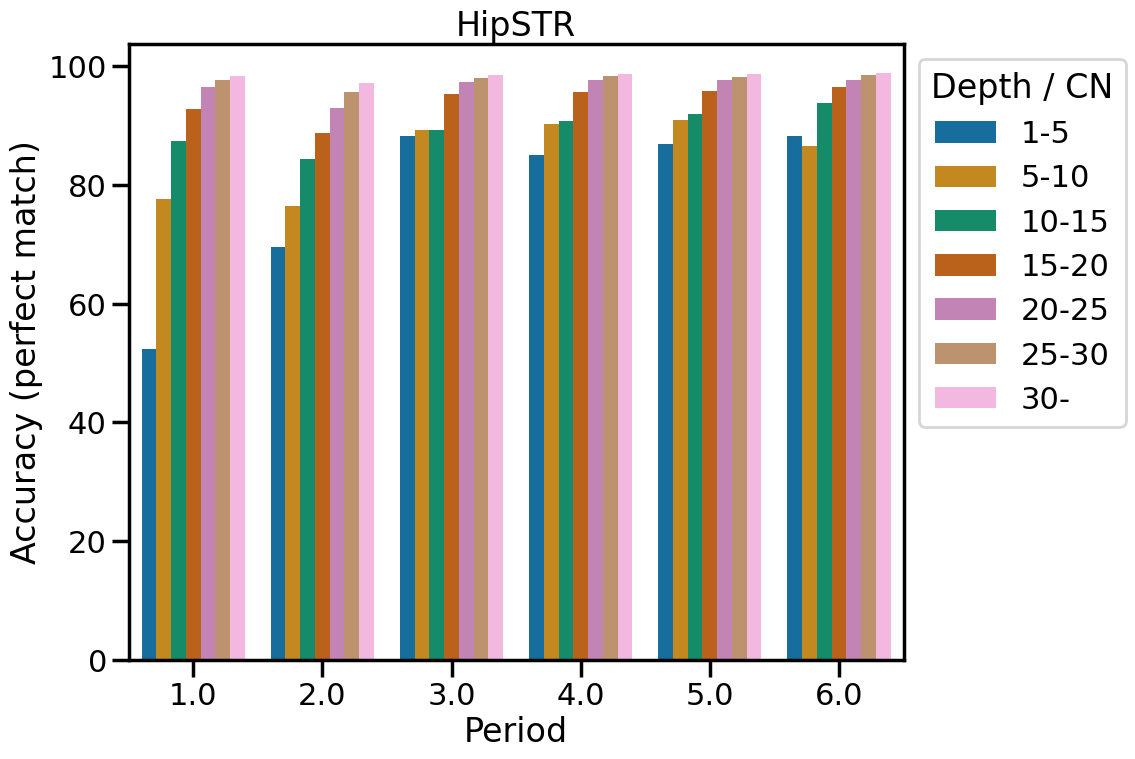

In [126]:
fig = plt.figure(figsize=(10, 8))

ax = sns.barplot(
    df_plot,
    x="period",
    y="accuracy",
    hue="depth",
    palette="colorblind"
)

ax.set(
    title="HipSTR",
    xlabel="Period",
    ylabel = "Accuracy (perfect match)"
)

_ = ax.get_legend().set(
    title="Depth / CN",
    bbox_to_anchor = (1, 1)
)

In [127]:
from scipy import ndimage

df_plot_density = (
    df_comparison
        .query("period >= 1 and period <= 6")
        .assign(depth = lambda x: x["depth"] / x["copy_number"])[["match", "period", "depth"]]
)

df_plot_constrain = (
    df_plot_density        
        .drop("period", axis=1)
        .groupby(["depth"], observed=True, as_index=False).agg(
            accuracy = ("match", lambda x: x.sum() / len(x)), 
            n_obs=("match", "count"))
        # .query(f"n_obs >= {min_obs}")
        
)

smooth = []
smooth = ndimage.gaussian_filter1d(df_plot_constrain["accuracy"], 3, mode="reflect")
# for group, data in df_plot_cn_period.groupby(["period"]):
#     current_smooth = ndimage.gaussian_filter1d(data["accuracy"], 3, mode="reflect")
#     smooth.append(current_smooth)
df_plot_constrain = df_plot_constrain.assign(smooth = smooth)


df_plot_constrain_period = (
    df_plot_density
        .groupby(["period", "depth"], observed=True, as_index=False).agg(
            accuracy = ("match", lambda x: x.sum() / len(x)), 
            n_obs=("match", "count"))
        # .query(f"n_obs >= {min_obs}")
        
)

smooth = []
for group, data in df_plot_constrain_period.groupby(["period"]):
    current_smooth = ndimage.gaussian_filter1d(data["accuracy"], 3, mode="reflect")
    smooth.append(current_smooth)
df_plot_constrain_period = df_plot_constrain_period.assign(smooth = np.concatenate(smooth))

df_plot_constrain_period

,period,depth,accuracy,n_obs,smooth
0,1,0.5,0.304688,256,0.410046
1,1,1.0,0.394366,284,0.421832
2,1,1.5,0.386935,199,0.443834
3,1,2.0,0.479087,263,0.473354
4,1,2.5,0.484536,194,0.507269
...,...,...,...,...,...
1040,6,97.5,1.000000,1,0.950649
1041,6,107.0,1.000000,1,0.968214
1042,6,109.0,1.000000,1,0.981264
1043,6,116.0,1.000000,1,0.989502


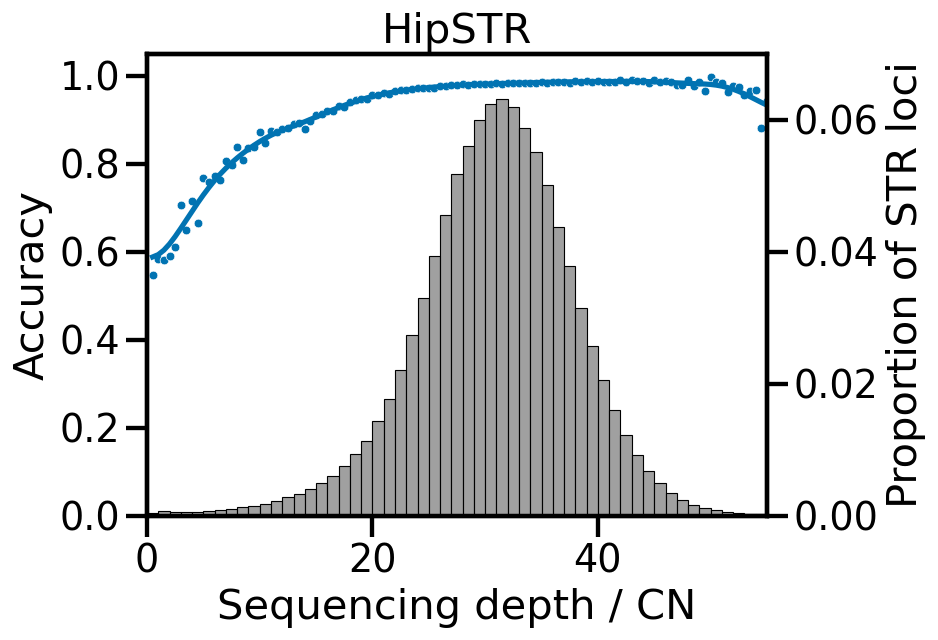

In [128]:
fig = plt.figure(dpi=125)

ax = sns.lineplot(
    df_plot_constrain,
    x = "depth",
    y = "smooth",
    color=sns.color_palette("colorblind")[0],
    # linewidth=2,
    legend=False
)

ax = sns.scatterplot(
    df_plot_constrain,
    x = "depth",
    y = "accuracy",
    color=sns.color_palette("colorblind")[0],
    s=25,
    ax = ax,
    legend=False
)

ax.set(
    title = "HipSTR",
    xlabel = "Sequencing depth / CN",
    ylabel = "Accuracy",
    ylim = (0, 1.05),
    xlim = (0, 55)
)

ax2 = ax.twinx()
ax2 = sns.histplot(
    df_plot_density,
    x = "depth",
    discrete=True,
    stat="proportion",
    color="grey",
    ax=ax2,
)
ax2.set(
    ylabel="Proportion of STR loci",
    ylim=(0, 0.07),
)

plt.show()